In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [2]:
trans = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale(3)])


data = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_sets, test_sets = torch.utils.data.random_split(data, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

# edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
# edge_test_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans)
# train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
test_sets_dark = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
labels = data.classes
# print(len(edge_train_sets))
# print(len(edge_test_sets))
print(len(train_sets))
print(len(test_sets))
print(len(labels))
# print(test_sets)
# print(edge_test_sets)

# print(len(labels))
# for i in range(4):
#     img, label = train_sets[i]
#     print(labels[label])
#     plt.subplot(241 + i)
#     plt.imshow(np.clip(img.permute(1,2,0),0,1))
#     plt.tight_layout()
#     plt.show()
#     save_image(img, str(i)+'_.jpg')


26221
6556
51


In [3]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
random_train_list = list(range(1, len(train_sets)))
random.shuffle(random_train_list)
random_test_list = list(range(1, len(test_sets)))
random.shuffle(random_test_list)

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
# edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
print(len(train_loader))
test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
test_loader_dark = DataLoader(test_sets_dark, batch_size = 32, sampler = random_test_list)
# edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_test_list)

820


In [4]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [5]:
resnet101 = torchvision.models.resnet101(pretrained=True)
resnet101 = resnet101.cuda()

In [8]:
#모델 학습
print(len(train_loader))
print(len(test_loader))

criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet101.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)
learning_rate = 1e-4
optimizer = optim.Adam(resnet101.parameters(), lr=learning_rate)

# hyper-parameters
num_epochs = 10
num_batches = 32

resnet101.train()
max_acc = 20
saved_trn_acc = 0

trn_loss_list = []
val_loss_list = []
val_loss_list_dark = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader):
        x, label = data

        x = x.cuda()
        label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = resnet101(x)               
        _, predicted = torch.max(model_output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            resnet101.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                val_total = 0
                val_correct = 0
                val_loss_dark = 0.0
                val_total_dark = 0
                val_correct_dark = 0
                
                count = 0
                for j, (val) in enumerate(test_loader):
                    count += 1
                    val_x, val_label = val
                    val_x = val_x.cuda()
                    val_label =val_label.cuda()

                    val_output = resnet101(val_x)
                    _, predicted = torch.max(val_output.data, 1)
                    val_total += val_label.size(0)
                    val_correct += (predicted == val_label).sum().item()
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if count >= 3:
                        break
                count = 0
                for j, (val) in enumerate(test_loader_dark):
                    count += 1
                    val_x, val_label_dark = val
                    val_x = val_x.cuda()
                    val_label_dark =val_label_dark.cuda()

                    val_output_dark = resnet101(val_x)
                    _, predicted = torch.max(val_output_dark.data, 1)
                    val_total_dark += val_label_dark.size(0)
                    val_correct_dark += (predicted == val_label_dark).sum().item()
                    v_loss = criterion(val_output_dark, val_label_dark)
                    val_loss_dark += v_loss
                    if count < 2 and (100 * val_correct_dark / val_total_dark) < max_acc:
                        break
               
                print("----------------testing data: "+ str(j * len(test_loader)))
                acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
                print("train acc1 : {}, acc5 : {}".format(acc1[0], acc5[0])) 
                print('Accuracy of the network on the train images: %f %%' % (100 * correct / total))

                acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                print('Accuracy of the network on the test images: %f %%' % (100 * val_correct / val_total))

                acc1, acc5 = accuracy(val_output_dark, val_label_dark, topk=(1, 5))
                print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                print('Accuracy of the network on the dark test images: %f %%' % (100 * val_correct_dark / val_total_dark))
                if (100 * val_correct / val_total) > 90 and (100 * val_correct_dark / val_total_dark) > max_acc:
                    max_acc = (100 * val_correct_dark / val_total_dark)
                    saved_trn_acc = (100 * val_correct / val_total)
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val_dark loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, len(train_loader), trn_loss / len(train_loader), val_loss / 3, val_loss_dark / 3
            ))
            print("max accuracy : {:.4f}".format(max_acc))
                    
            
            trn_loss_list.append(trn_loss/len(train_loader))
            val_loss_list.append(val_loss/3)
            val_loss_list_dark.append(val_loss_dark/len(test_sets_dark))
            # val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            resnet101.train()
        
        # del (memory issue)
        # del lossadw
        del model_output
   # scheduler.step()
#plotting the loss chart 

820
205
----------------testing data: 0
train acc1 : 62.5, acc5 : 75.0
Accuracy of the network on the train images: 62.500000 %
test acc1 : 0.0, acc5 : 0.0
Accuracy of the network on the test images: 0.000000 %
test acc1 : 0.0, acc5 : 0.0
Accuracy of the network on the dark test images: 0.000000 %
epoch: 1/10 | step: 1/820 | trn loss: 0.0023 | val loss: 17.5220 | val_dark loss: 5.5047
max accuracy : 20.0000
----------------testing data: 0
train acc1 : 37.5, acc5 : 75.0
Accuracy of the network on the train images: 18.935644 %
test acc1 : 37.5, acc5 : 75.0
Accuracy of the network on the test images: 36.458333 %
test acc1 : 9.375, acc5 : 34.375
Accuracy of the network on the dark test images: 9.375000 %
epoch: 1/10 | step: 101/820 | trn loss: 0.5220 | val loss: 2.2972 | val_dark loss: 1.1511
max accuracy : 20.0000
----------------testing data: 41820
train acc1 : 56.25, acc5 : 75.0
Accuracy of the network on the train images: 33.566542 %
test acc1 : 50.0, acc5 : 93.75
Accuracy of the netwo

KeyboardInterrupt: 

In [54]:
resnet101.eval()
with torch.no_grad(): # very very very very important!!!
    
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    for j, (val) in enumerate(edge_test_loader):
        val_x, val_label = val
        val_x = val_x.cuda()
        val_label =val_label.cuda()
        val_output = resnet101(val_x)
        _, predicted = torch.max(val_output.data, 1)
        val_total += val_label.size(0)
        val_correct += (predicted == val_label).sum().item()
        v_loss = criterion(val_output, val_label)
        val_loss += v_loss
    print("----------------testing data: "+ str(j * len(test_loader)))
    acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
    print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
    print('Accuracy of the network on the test images: %f %%' % (100 * val_correct / val_total))
                       

----------------testing data: 43890
test acc1 : 100.0, acc5 : 100.0
Accuracy of the network on the test images: 88.458663 %


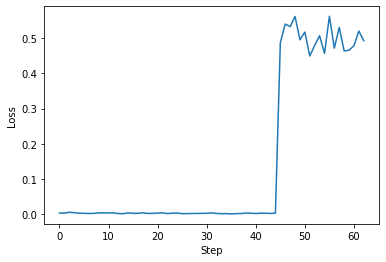

In [51]:
val = []
for l in val_loss_list:
    val.append(l.cpu())
plt.plot(val[27:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

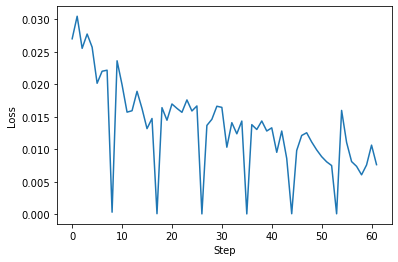

In [52]:
plt.plot(trn_loss_list[28:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [55]:
#모델 저장
torch.save(resnet101, 'resnet_whole_edge_img_93.75%.pt')
# model1 = torch.load('resnet_whole_img_89%.pt')

In [ ]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
random_train_list = list(range(1, len(train_sets)))
random.shuffle(random_train_list)
random_test_list = list(range(1, len(test_sets)))
random.shuffle(random_test_list)

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
print(len(train_loader))
test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_test_list)

In [44]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(test_loader))

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)
# learning_rate = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# hyper-parameters
num_epochs = 10
num_batches = 32

model.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    total = 0
    correct = 0
    for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
        x, label = data
        x2, label2 = edge_data

        x = x.cuda()
        label = label.cuda()
        x2 = x2.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model(x, x2)               
        _, predicted = torch.max(model_output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            model.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                val_total = 0
                val_correct = 0
                for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                    val_x, val_label = val
                    val_x2, val_label2 = edge_val
                    val_x = val_x.cuda()
                    val_x2 = val_x2.cuda()
                    val_label =val_label.cuda()

                    val_output = model(val_x, val_x2)
                    _, predicted = torch.max(val_output.data, 1)
                    val_total += val_label.size(0)
                    val_correct += (predicted == val_label).sum().item()
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if epoch < 3:
                        break
                print("----------------testing data: "+ str(j * len(test_loader)))
                acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
                print("train acc1 : {}, acc5 : {}".format(acc1[0], acc5[0])) 
                print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

                acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                print('Accuracy of the network on the test images: %d %%' % (100 * val_correct / val_total))
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, len(train_loader), trn_loss / len(train_loader), val_loss / len(test_loader)
            ))
                    
            
            trn_loss_list.append(trn_loss/len(train_loader))
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            model.train()
        
        # del (memory issue)
        # del lossadw
        del model_output
    scheduler.step()

837
210


NameError: name 'model' is not defined